<a href="https://colab.research.google.com/github/IqbalLx/Machine-Learning-Deep-Learning-Project/blob/master/Sunspot_Time_Series_Forecasting_Iqbal_Maulana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sunspot Time Series Forecasting
---

## Prepare dataset from Kaggle

In [ ]:
from google.colab import files
files.upload() #Upload kaggle API

In [ ]:
!pip install -q kaggle                                                           # Installing required kaggle library
!mkdir ~/.kaggle                                                                 # Create new Kaggle directory to store our API key in root
!cp kaggle.json ~/.kaggle                                                        # Copy the API to root folder
!chmod 600 ~/.kaggle/kaggle.json                                                 # Give access
!kaggle datasets download -d robervalt/sunspots                                  # Download dataset

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 38.2MB/s]


In [ ]:
!unzip sunspots.zip

Archive:  sunspots.zip
  inflating: Sunspots.csv            


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("Sunspots.csv")
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3252 non-null   int64  
 1   Date                               3252 non-null   object 
 2   Monthly Mean Total Sunspot Number  3252 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.3+ KB


## Dataset cleaning

In [ ]:
df.columns = ["useless", "date", "value"]
df.head()

,useless,date,value
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
df.drop(["useless", "date"], axis=1, inplace=True)

## Dataset overview

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

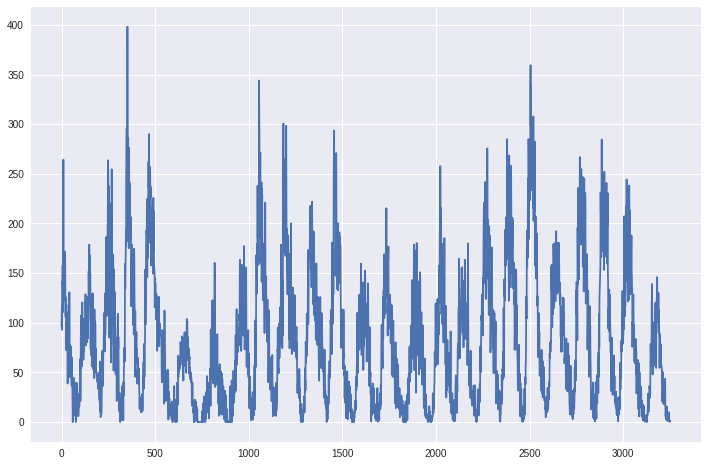

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df.value)
plt.show()

Lets take a closer look!

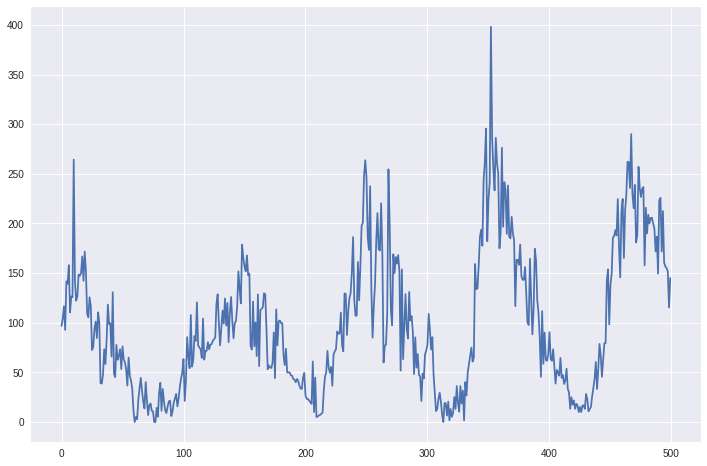

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df.value[:500])
plt.show()

Showing no trend, but very clear seasonality

## Modeling

### Prepare dataset for training

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
def generate_window(series, window_size, buffer_size, batch_size):
  #prepare dataset
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)                    # Convert to tensor format
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # Create windowed dataset w same size
  dataset = dataset.flat_map(lambda x: x.batch(window_size + 1))          # Convert into array form
  dataset = dataset.map(lambda s: (s[:-1], s[-1]))                        # Splitting into features and label

  #preprocess dataset
  dataset = dataset.shuffle(buffer_size=buffer_size)                      # Shuffle order
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)              # Create batch

  return dataset

In [ ]:
WINDOW_SIZE = 60
BUFFER_SIZE = 1000
BATCH_SIZE = 64

SPLIT_SIZE = 0.8

total_size = df.count()[0]
train_size = int(SPLIT_SIZE*total_size)

x_train = df.value[:train_size]
x_val = df.value[train_size:]

#### Train data

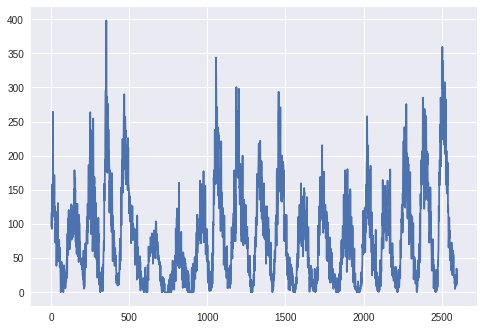

In [ ]:
plt.plot(x_train)
plt.show()

#### Validation data


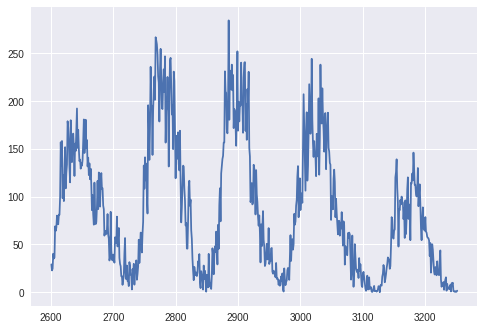

In [ ]:
plt.plot(x_val)
plt.show()

#### Windowed train dataset

In [ ]:
dataset = generate_window(x_train, WINDOW_SIZE, BUFFER_SIZE, BATCH_SIZE)

### Build model

In [ ]:
model = tf.keras.models.Sequential([
                  tf.keras.layers.Conv1D(64, 5, strides=1, padding="same", activation="relu", input_shape=[None, 1]),
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(1),
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["mae"])                     

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, None, 64)          384       
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 512)               657408    
_________________________________________________________________
dense_63 (Dense)             (None, 16)                8208      
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 17        
Total params: 666,017
Trainable params: 666,017
Non-trainable params: 0
_________________________________________________________________


### Training

In [ ]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='loss', factor=0.1, patience=5, verbose=0, mode='auto',
                    min_delta=0.0001, cooldown=3, min_lr=1e-10
                )

In [ ]:
history = model.fit(dataset, epochs=700, callbacks=[reduce_on_plateau])

Epoch 1/700
40/40 [==============================] - 2s 39ms/step - loss: 60.6772 - mae: 61.1738
Epoch 2/700
40/40 [==============================] - 1s 36ms/step - loss: 35.4522 - mae: 35.9460
Epoch 3/700
40/40 [==============================] - 1s 36ms/step - loss: 25.6066 - mae: 26.1000
Epoch 4/700
40/40 [==============================] - 1s 36ms/step - loss: 21.8861 - mae: 22.3792
Epoch 5/700
40/40 [==============================] - 1s 36ms/step - loss: 19.7618 - mae: 20.2533
Epoch 6/700
40/40 [==============================] - 1s 36ms/step - loss: 18.8237 - mae: 19.3154
Epoch 7/700
40/40 [==============================] - 1s 36ms/step - loss: 18.5626 - mae: 19.0548
Epoch 8/700
40/40 [==============================] - 1s 37ms/step - loss: 18.0742 - mae: 18.5660
Epoch 9/700
40/40 [==============================] - 1s 36ms/step - loss: 18.1695 - mae: 18.6616
Epoch 10/700
40/40 [==============================] - 1s 36ms/step - loss: 17.7250 - mae: 18.2160
Epoch 11/700
40/40 [=========

### Plot training result

In [ ]:
def plot(history):
  graf = history.history
  graf['epoch'] = history.epoch

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

  ax[0].plot(graf['epoch'], graf['loss'], label='Loss')
  ax[0].plot(graf['epoch'], graf['mae'], label='MAE', color='orange')

  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Score')
  ax[0].set_title('Loss')
  ax[0].legend()

  ax[1].plot(graf['epoch'][600:], graf['loss'][600:], label='Last 100 Loss')
  ax[1].plot(graf['epoch'][600:], graf['mae'][600:], label='Last 100 MAE', color='orange')

  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Score')
  ax[1].set_title('Last 100 Loss')
  ax[1].legend()

  ax[2].plot(graf['epoch'], graf['lr'], label='Learning Rate')

  ax[2].set_xlabel('Epochs')
  ax[2].set_ylabel('Value')
  ax[2].set_title('Learning Rate')

  return plt.show()

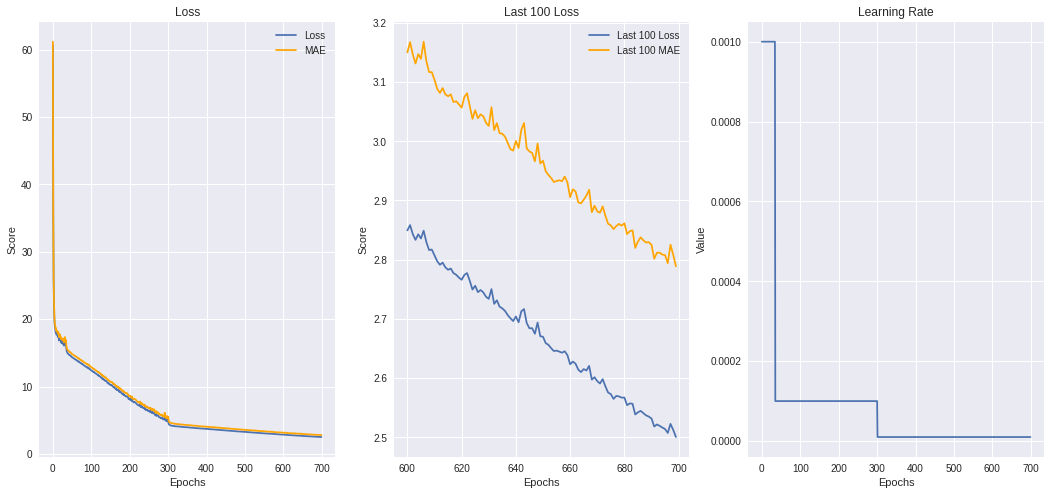

In [ ]:
plot(history)

### Show performance on validation data

In [ ]:
def forecast_model(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    
    forecast = model.predict(dataset)

    return forecast

In [ ]:
all_value = np.array(df.value)
forecast = forecast_model(model, all_value[..., np.newaxis], WINDOW_SIZE)

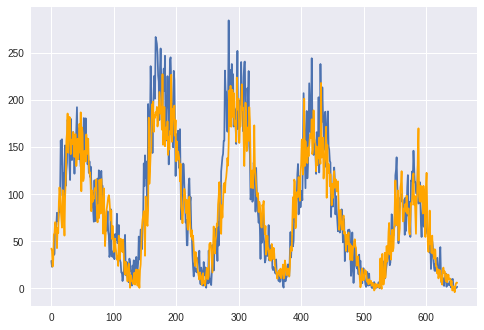

In [ ]:
forecast_val = forecast[train_size-WINDOW_SIZE:-1].flatten()

plt.plot(x_val)
plt.plot(forecast_val, c='orange')
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_val, forecast_val).numpy()

22.93394